In [ ]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.utils import np_utils
import os
import numpy as np
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator 
import cv2
import zipfile
from google.colab import drive


Carga de datos


In [ ]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/Shareddrives/PovertyModels/data/Data_Rural_vs_Urbano.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
train_dir = '/tmp/Data_Rural_vs_Urbano/Train'
validation_dir = '/tmp/Data_Rural_vs_Urbano/Test'

# Implementación ResNet50

In [ ]:
width_shape = 224
height_shape = 224
num_classes = 2
epochs = 50
batch_size = 16

In [ ]:
train_datagen = ImageDataGenerator(  
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input)

valid_datagen = ImageDataGenerator(    
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(  
    train_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    #save_to_dir='',
    class_mode='categorical')

validation_generator = valid_datagen.flow_from_directory(  
    validation_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    #save_to_dir='',
    class_mode='categorical')

Found 878 images belonging to 2 classes.
Found 110 images belonging to 2 classes.


In [ ]:
nb_train_samples = 878
nb_validation_samples = 110

In [ ]:

from keras.applications.resnet50 import ResNet50

image_input = Input(shape=(width_shape, height_shape, 3))

m_Resnet50 = ResNet50(input_tensor=image_input, include_top=False,weights='imagenet')

m_Resnet50.summary()

last_layer = m_Resnet50.layers[-1].output

x= Flatten(name='flatten')(last_layer)
x = Dense(128, activation='relu', name='fc1')(x)
x=Dropout(0.3)(x)
x = Dense(128, activation='relu', name='fc2')(x)
x=Dropout(0.3)(x)
out = Dense(num_classes, activation='softmax', name='output')(x)
custom_model = Model(image_input, out)
custom_model.summary()

# freeze all the layers except the dense layers
for layer in custom_model.layers[:-6]:
    layer.trainable = False

    
#custom_model.summary()

custom_model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

In [ ]:

model_history = custom_model.fit_generator(  
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    steps_per_epoch=nb_train_samples//batch_size,
    validation_steps=nb_validation_samples//batch_size)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
 4/54 [=>............................] - ETA: 2:13 - loss: 3.1686 - accuracy: 0.4349

KeyboardInterrupt: ignored

In [ ]:
custom_model.save("/content/drive/Shareddrives/PovertyModels/Modelos/modelRvU_Resnet.h5")

In [ ]:
custom_model.save_weights("/content/drive/Shareddrives/PovertyModels/Modelos/RvUpesos.h5")

# **Gráficas de entrenamiento y validacion (accuracy-loss)**

In [ ]:
def plotTraining(hist, epochs, typeData):
    
    if typeData=="loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'-r',label='Loss Training')
    if typeData=="accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'-r',label='Accuracy Training')
    if typeData=="val_loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['val_loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'--b',label='Loss Validate')
    if typeData=="val_accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['val_accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'--b',label='Training Validate')
        

    plt.rc('xtick',labelsize=24)
    plt.rc('ytick',labelsize=24)
    plt.rc('legend', fontsize=18) 
    plt.legend()
    plt.xlabel('Number of Epochs',fontsize=24)
    plt.grid(True)

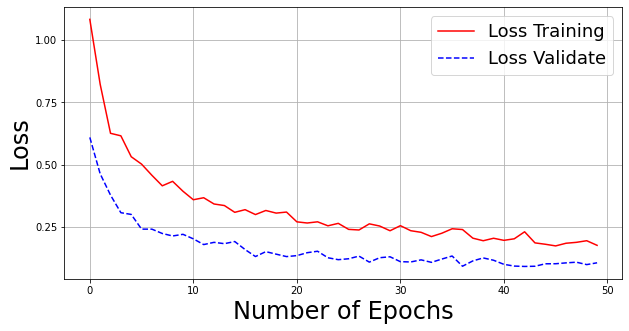

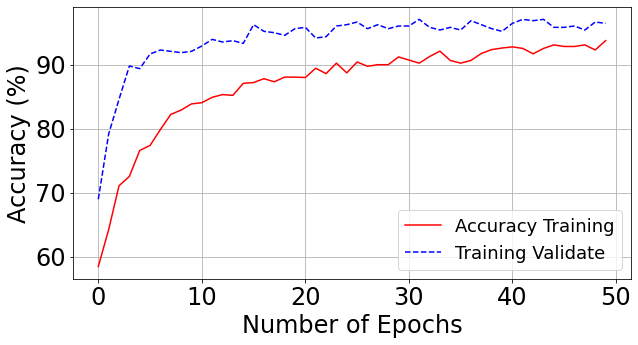

In [ ]:
plotTraining(model_history,epochs,"loss")
plotTraining(model_history,epochs,"accuracy")
plotTraining(model_history,epochs,"val_loss")
plotTraining(model_history,epochs,"val_accuracy")